# Aim

Inverse detection efficiency completeness calculation on TESS data.

IDEM as in Appendix A of Hsu 2018 (https://arxiv.org/pdf/1803.10787.pdf).

In [24]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
import sys
sys.path.append('..')
from tqdm.notebook import tqdm
from os import path
from dev import utils

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [38]:
import os
os.path.abspath(os.path.dirname(os.getcwd())) + "/data/tesstargets/"

'/Users/adityasengupta/projects/pals/tesscomp-prototyping/data/tesstargets/'

In [55]:
stellar = utils.get_tess_stellar().drop_duplicates("ID")

In [56]:
print([k for k in stellar.keys()], end=" ")

['Unnamed: 0', 'ID', 'version', 'HIP', 'TYC', 'UCAC', 'TWOMASS', 'SDSS', 'ALLWISE', 'GAIA', 'APASS', 'KIC', 'objType', 'typeSrc', 'ra', 'dec', 'POSflag', 'pmRA', 'e_pmRA', 'pmDEC', 'e_pmDEC', 'PMflag', 'plx', 'e_plx', 'PARflag', 'gallong', 'gallat', 'eclong', 'eclat', 'Bmag', 'e_Bmag', 'Vmag', 'e_Vmag', 'umag', 'e_umag', 'gmag', 'e_gmag', 'rmag', 'e_rmag', 'imag', 'e_imag', 'zmag', 'e_zmag', 'Jmag', 'e_Jmag', 'Hmag', 'e_Hmag', 'Kmag', 'e_Kmag', 'TWOMflag', 'prox', 'w1mag', 'e_w1mag', 'w2mag', 'e_w2mag', 'w3mag', 'e_w3mag', 'w4mag', 'e_w4mag', 'GAIAmag', 'e_GAIAmag', 'Tmag', 'e_Tmag', 'TESSflag', 'SPFlag', 'Teff', 'e_Teff', 'logg', 'e_logg', 'MH', 'e_MH', 'rad', 'e_rad', 'mass', 'e_mass', 'rho', 'e_rho', 'lumclass', 'lum', 'e_lum', 'd', 'e_d', 'ebv', 'e_ebv', 'numcont', 'contratio', 'disposition', 'duplicate_id', 'priority', 'eneg_EBV', 'epos_EBV', 'EBVflag', 'eneg_Mass', 'epos_Mass', 'eneg_Rad', 'epos_Rad', 'eneg_rho', 'epos_rho', 'eneg_logg', 'epos_logg', 'eneg_lum', 'epos_lum', 'eneg

In [57]:
stellar

,Unnamed: 0,ID,version,HIP,TYC,UCAC,TWOMASS,SDSS,ALLWISE,GAIA,...,RA_orig,Dec_orig,e_RA_orig,e_Dec_orig,raddflag,wdflag,objID,TICID,Camera,CCD
0,0,201235927,20190415,-1,8464-00498-1,180-000014,00002830-5404296,-1,J000028.29-540429.7,4971992409732044928,...,0.117907,-54.074922,0.036299,0.030279,1.0,0,507486390,201235927,2,2
1,1,201247149,20190415,-1,8470-00866-1,157-000001,00000193-5843068,-1,J000001.89-584306.5,4919074289477561472,...,0.007807,-58.718474,0.020633,0.018711,1.0,0,507487171,201247149,2,2
2,2,201247436,20190415,-1,8470-01087-1,151-000015,00011622-5949402,-1,J000116.25-594940.3,4918008072436519040,...,0.317765,-59.827872,0.020750,0.018449,1.0,0,507487417,201247436,2,2
3,3,201248233,20190415,-1,-1,172-000020,00012547-5539491,-1,J000125.80-553948.2,4923563835972259456,...,0.358133,-55.663285,0.038647,0.036456,1.0,0,507488214,201248233,2,2
4,4,201248310,20190415,-1,8467-01288-1,174-000020,00005899-5517023,-1,J000059.02-551702.0,4923637331452674688,...,0.246014,-55.283879,0.017768,0.016856,1.0,0,507488291,201248310,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,19995,325525231,20190415,-1,-1,037-015611,23573768-8247143,-1,J235737.73-824714.3,6350261433791466880,...,359.407214,-82.787325,0.024433,0.019693,0.0,0,1726185600,325525231,3,2
19996,19996,327856083,20190415,-1,-1,-1,23572841-8621078,-1,J235728.44-862107.9,6343367117929826048,...,359.367910,-86.352216,0.528593,0.448568,1.0,1,1726186486,327856083,3,3
19997,19997,327856208,20190415,-1,-1,017-007154,23573581-8646411,-1,J235735.31-864641.5,6343331143283809152,...,359.399858,-86.778104,0.047661,0.039175,1.0,1,1726186547,327856208,3,3
19998,19998,2054551666,20190415,-1,-1,-1,-1,-1,-1,6352373385175322496,...,359.142920,-80.499279,0.086944,0.065817,-1.0,1,1726282677,2054551666,3,2


In [48]:
planetary = utils.get_tois()

In [49]:
planetary.keys()

Index(['Source Pipeline', 'TIC', 'Full TOI ID', 'TOI Disposition',
       'TIC Right Ascension', 'TIC Declination', 'TMag Value',
       'TMag Uncertainty', 'Orbital Epoch Value', 'Orbital Epoch Error',
       'Orbital Period Value', 'Orbital Period Error',
       'Transit Duration Value', 'Transit Duration Error',
       'Transit Depth Value', 'Transit Depth Error', 'Sectors',
       'Public Comment', 'Surface Gravity Value',
       'Surface Gravity Uncertainty', 'Signal ID', 'Star Radius Value',
       'Star Radius Error', 'Planet Radius Value', 'Planet Radius Error',
       'Planet Equilibrium Temperature (K) Value',
       'Effective Temperature Value', 'Effective Temperature Uncertainty',
       'Effective Stellar Flux Value', 'Signal-to-noise', 'Centroid Offset',
       'TFOP Master', 'TFOP SG1a', 'TFOP SG1b', 'TFOP SG2', 'TFOP SG3',
       'TFOP SG4', 'TFOP SG5', 'Alerted', 'Updated'],
      dtype='object')

In [51]:
planetary = planetary[np.isfinite(planetary['Planet Radius Value'])]

(array([ 1.,  0.,  1.,  0.,  2.,  2.,  3.,  2.,  6.,  9., 11.,  9., 13.,
        20., 13., 17., 22., 27., 24., 25., 40., 66., 53., 49., 46., 41.,
        45., 44., 41., 42., 32., 30., 29., 40., 22., 28., 28., 35., 34.,
        33., 25., 35., 29., 43., 38., 44., 44., 54., 71., 65., 74., 74.,
        55., 45., 46., 49., 46., 38., 24., 18., 11., 11., 13.,  9.,  5.,
         4.,  3.,  1.,  4.,  3.,  0.,  4.,  0.,  3.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  2.]),
 array([-0.4661678 , -0.4049576 , -0.34374741, -0.28253722, -0.22132703,
        -0.16011684, -0.09890665, -0.03769646,  0.02351373,  0.08472392,
         0.14593411,  0.20714431,  0.2683545 ,  0.32956469,  0.39077488,
         0.45198507,  0.51319526,  0.57440545,  0.63561564,  0.69682583,
         0.75803602,  0.81924621,  0.88045641,  0.9416666 ,  1.00287679,
         1.06408698,  1.12529717,  1.18650736,  1.24771755,  1.308927

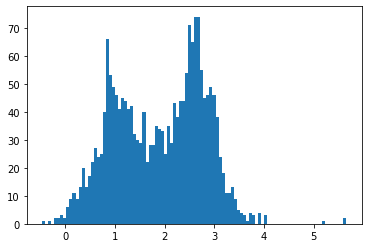

In [52]:
# let's group all these planets into buckets based on planet size and orbital period!
radii = np.array(planetary['Planet Radius Value'])
plt.hist(np.log(radii), bins=100)

/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/usr/local/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


(array([ 2.,  3.,  1.,  3.,  3.,  1.,  3.,  4.,  8.,  6., 14., 11., 10.,
        17., 11.,  9., 22., 16., 14., 17., 18., 22., 19., 32., 28., 34.,
        33., 31., 37., 38., 20., 38., 38., 36., 41., 52., 37., 55., 57.,
        67., 57., 50., 51., 63., 34., 55., 44., 48., 35., 32., 26., 31.,
        41., 31., 36., 51., 23., 31., 32., 27., 19., 22., 27., 17., 12.,
        11.,  9., 10.,  7.,  8.,  6.,  6.,  2.,  8.,  8.,  1.,  3.,  4.,
         7.,  1.,  1.,  2.,  3.,  0.,  2.,  2.,  2.,  2.,  1.,  0.,  1.,
         0.,  1.,  0.,  1.,  0.,  3.,  1.,  0.,  1.]),
 array([-1.3970318 , -1.32864037, -1.26024893, -1.19185749, -1.12346606,
        -1.05507462, -0.98668318, -0.91829175, -0.84990031, -0.78150887,
        -0.71311744, -0.644726  , -0.57633456, -0.50794313, -0.43955169,
        -0.37116025, -0.30276882, -0.23437738, -0.16598594, -0.09759451,
        -0.02920307,  0.03918837,  0.1075798 ,  0.17597124,  0.24436268,
         0.31275411,  0.38114555,  0.44953699,  0.51792842,  0.586319

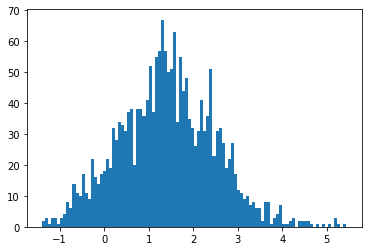

In [53]:
periods = np.array(planetary['Orbital Period Value'])
plt.hist(np.log(periods), bins=100)

Text(0, 0.5, 'Log-radius (ln Earth radii)')

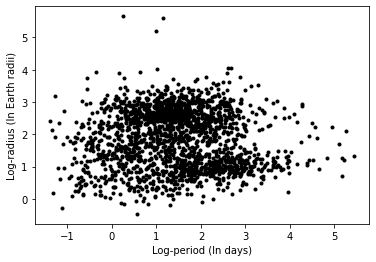

In [54]:
plt.plot(np.log(periods), np.log(radii), ".k")
plt.xlabel("Log-period (ln days)")
plt.ylabel("Log-radius (ln Earth radii)")

In [107]:
planetary = planetary[planetary['TOI Disposition'] == "PC"]
planetary = planetary[np.isfinite(planetary["Orbital Period Value"])]
combined = pd.merge(planetary, stellar, left_on="TIC", right_on="ID")
combined = combined[np.isfinite(combined["mass"])]
combined = combined[combined["mass"] >= 0.0]
rstars = combined['rad'].values 
mstars = combined['mass'].values
periods = combined['Orbital Period Value'].values
prads = combined['Planet Radius Value'].values
len(combined)

947

In [108]:
def get_a(period, mstar, Go4pi=2945.4625385377644/(4*np.pi*np.pi)):
    # dfm.io/posts/exopop
    """
    Compute the semi-major axis of an orbit in Solar radii.
    
    :param period: the period in days
    :param mstar:  the stellar mass in Solar masses
    
    """
    return (Go4pi*period*period*mstar) ** (1./3)

pgeoms = rstars / get_a(periods, mstars)

(array([573., 224.,  73.,  34.,  16.,  11.,   3.,   8.,   2.,   3.]),
 array([0.0043306 , 0.09462737, 0.18492413, 0.27522089, 0.36551766,
        0.45581442, 0.54611118, 0.63640795, 0.72670471, 0.81700147,
        0.90729823]),
 <a list of 10 Patch objects>)

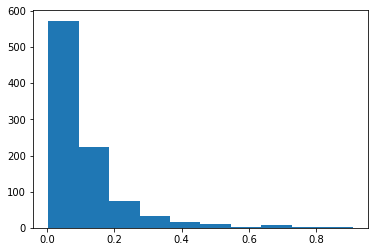

In [110]:
plt.hist(pgeoms)

In [ ]:
# these things should be an import from completeness.py
# except that this only uses pdet and not pwin

cdpp_cols = [k for k in stellar.keys() if k.startswith("rrmscdpp")]
cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)
pgam = gamma(4.65, loc=0., scale=0.98)
mesthres_cols = [k for k in stellar.keys() if k.startswith("mesthres")]
mesthres_vals = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                         dtype=float)

def pdet_combined(catalog):
    return pcomp_vectors(catalog, catalog['koi_period'].values, 
                         catalog['koi_prad'].values, catalog['koi_eccen'].values)

def pdet_vectors(stars, periods, rp, eccs):
    '''
    Self-contained, returns pcomp over matched arrays of planets around stars.
    '''
    cdpp_cols = [k for k in stellar.keys() if k.startswith("rrmscdpp")]
    cdpp_vals = np.array([k[-4:].replace("p", ".") for k in cdpp_cols], dtype=float)
    pgam = gamma(4.65, loc=0., scale=0.98)
    mesthres_cols = [k for k in stellar.keys() if k.startswith("mesthres")]
    mesthres_vals = np.array([k[-4:].replace("p", ".") for k in mesthres_cols],
                            dtype=float)
    mstars = stars['mass'].values
    rstars = stars['radius'].values
    cdpp = stars[cdpp_cols].values
    dataspan = stars['dataspan'].values
    dutycycle = stars['dutycycle'].values
    mesthres_cols_stars = stars[mesthres_cols].values

    return pcomp_star_vectors(mstars, rstars, cdpp, dataspan, dutycycle, mesthres_cols_stars, periods, rp, eccs)

def pdet_star_vectors(mstars, rstars, cdpp, dataspan, dutycycle, mesthres_cols_stars, periods, rp, eccs):
    c = 1.0874
    s = 1.0187
    Go4pi = 2945.4625385377644/(4*np.pi*np.pi)
    re = 0.009171
    aor = (Go4pi*periods*periods*mstars) ** (1./3) / rstars
    tau = 6 * periods * np.sqrt(1 - eccs**2) / aor

    # sigma = np.apply_along_axis(np.interp, 0, tau, cdpp_vals, cdpp)
    sigma = np.array([np.interp(tau[i], cdpp_vals, cdpp[i]) for i in range(len(tau))])
    # Compute the radius ratio and estimate the S/N.
    k = rp * re / rstars
    delta = 0.84 * k*k * (c + s*k)
    snr = delta * 1e6 / sigma

    # Scale by the estimated number of transits.
    ntrn = dataspan * dutycycle / periods
    mess = snr * np.sqrt(ntrn)
    mest = np.array([np.interp(tau[i], mesthres_vals, mesthres_cols_stars[i]) for i in range(len(tau))])
    x = mess - 4.1 - (mest - 7.1)
    pdets = pgam.cdf(x)
    
    return pdets

In [ ]:
planetary_params = np.vstack((planetary.koi_period.values, 
                              planetary.koi_prad.values, planetary.koi_eccen.values)).T

In [ ]:
if not path.exists('../data/idem_pdets.npy'):
    pdet_ij = np.empty((len(planetary), len(stellar)))
    for i, params in enumerate(tqdm(planetary_params, total=len(planetary))):
        pdet_ij[i] = pcomp_vectors(stellar, *params)
    np.save('../data/idem_pdets.npy', pdet_ij)
else:
    pdet_ij = np.load('../data/idem_pdets.npy')

In [ ]:
pdet_i = np.nanmean(pdet_ij, axis=1)

In [ ]:
np.save('../data/idem_pdets_i.npy', pdet_i)

In [ ]:
plt.hist(pdet_i)

In [ ]:
weights = np.nan_to_num(1 / (pdet_i * pgeoms))

In [ ]:
period_bins = np.array([0.5, 1.25, 2.5, 5, 10, 20, 40, 80, 160, 320])
rp_bins = np.array([0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3, 4, 6, 8, 12, 16])
counts = np.histogram2d(periods, prads, bins=[period_bins, rp_bins])[0]
N = np.histogram2d(periods, prads, bins=[period_bins, rp_bins], weights=weights)
f = N[0] / len(stellar)

In [ ]:
plt.imshow(f)
plt.colorbar()
_ = plt.xticks(list(range(len(rp_bins))), rp_bins)
plt.xlabel(r"Radius ($R_E$)")
_ = plt.yticks(list(range(len(period_bins))), period_bins)
plt.ylabel("Period (days)")

In [ ]:
sigmas = np.divide(f, np.sqrt(counts), out=np.zeros_like(f), where=counts!=0)

In [ ]:
plt.imshow(sigmas)
plt.colorbar()